In [2]:
# Para modelos univariados: ante problemas de no estacionariedad, se toma primeras diferencias hasta estacionarizar la serie.
# Para modelos multivariados: no vale tomar primeras diferencias y luego estimar un VAR cuando las variables están cointegradas. 
# En este caso, se usan algunas de las siguiente representaicones:

# Veremos VMA (Vector Moving Average, aparecen lags de los errores) y VECM (Vector Error Correction Model, incluye término en niveles).

In [1]:
import numpy as np
import pandas as pd

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 2-20250504\pv.txt"
df = pd.read_csv(path, delimiter="\t", decimal=".")
df.head()

,Name,dateid01,coin,martin,rdiv,rsp
0,NaN,1871-01-01,-0.038897,0.045976,0.005896,0.100680
1,NaN,1872-01-01,-0.049066,0.031073,0.006565,0.106346
2,NaN,1873-01-01,-0.059527,0.015629,0.007269,0.112555
3,NaN,1874-01-01,-0.049598,0.023188,0.007604,0.130415
4,NaN,1875-01-01,-0.063111,0.011193,0.007389,0.111823


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      0 non-null      float64
 1   dateid01  117 non-null    object 
 2   coin      115 non-null    float64
 3   martin    117 non-null    float64
 4   rdiv      117 non-null    float64
 5   rsp       117 non-null    float64
dtypes: float64(5), object(1)
memory usage: 5.6+ KB


<Axes: >

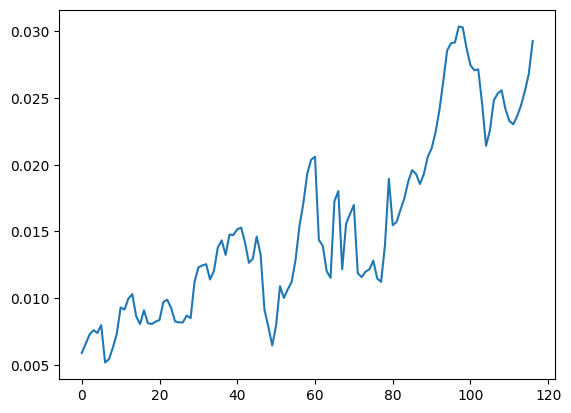

In [24]:
df['rdiv'].plot()

In [2]:
df_f = df.iloc[:75,:].copy()
df_f

,Name,dateid01,coin,martin,rdiv,rsp
0,NaN,1871-01-01,-0.038897,0.045976,0.005896,0.100680
1,NaN,1872-01-01,-0.049066,0.031073,0.006565,0.106346
2,NaN,1873-01-01,-0.059527,0.015629,0.007269,0.112555
3,NaN,1874-01-01,-0.049598,0.023188,0.007604,0.130415
4,NaN,1875-01-01,-0.063111,0.011193,0.007389,0.111823
...,...,...,...,...,...,...
70,NaN,1941-01-01,-0.149732,-0.143335,0.016986,0.252392
71,NaN,1942-01-01,-0.101366,-0.058778,0.011871,0.179678
72,NaN,1943-01-01,-0.082569,-0.037884,0.011575,0.191461
73,NaN,1944-01-01,-0.061828,-0.020045,0.011985,0.221910


In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# # 1a) Convierte tu columna de fecha
# df_f['dateid01'] = pd.to_datetime(df_f['dateid01'])

# # 1b) Ponla como índice
# df_f = df_f.set_index('dateid01')

# # 1c) Ahora conviertes a PeriodIndex trimestral
# df_f.index = df_f.index.to_period('Q')

dlgp_q = df_f['rdiv']

# --- 3) ADF Test (constante, SIC=BIC, maxlag=14) ---
adf_res = adfuller(dlgp_q, maxlag=11, regression='c', autolag='BIC')
adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adf_res

print("Null Hypothesis: DLGP has a unit root")
print("Exogenous: Constant")
print(f"Lag Length: {used_lag} (automatic via SIC, maxlag=11)\n")
print("\t\t t-Statistic\tProb.*")
print(f"ADF test statistic\t {adf_stat:.6f}\t {pvalue:.4f}\n")

print("Test critical values (MacKinnon 1996):")
for lvl, val in crit_vals.items():
    print(f"  {lvl} level\t {val:.6f}")
print("\n*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.\n")

# --- 4) Ecuación auxiliar ΔDLGP_t = α + β·DLGP_{t−1} + ∑γ_iΔDLGP_{t−i} + ε_t ---
df_aux = pd.DataFrame({
    'd_dlgp': dlgp_q.diff(),
    'dlgplag': dlgp_q.shift(1)
})
for i in range(1, used_lag+1):
    df_aux[f'd_dlgp_lag{i}'] = df_aux['d_dlgp'].shift(i)
df_aux = df_aux.dropna()

y = df_aux['d_dlgp']
cols = ['dlgplag'] + [f'd_dlgp_lag{i}' for i in range(1, used_lag+1)]
X = sm.add_constant(df_aux[cols])
model = sm.OLS(y, X).fit()

# --- 5) Tabla de coeficientes ---
print(model.summary().tables[1])

# --- 6) Métricas estilo EViews ---

# Durbin–Watson
dw_stat = durbin_watson(model.resid)

# HQIC (manual)
n = model.nobs
k = model.df_model + 1
hqic_val = -2*model.llf + 2*k*np.log(np.log(n))

# Información “por observación” (EViews):
aic_per_obs  = model.aic / n
bic_per_obs  = model.bic / n
hqic_per_obs = hqic_val   / n

print(f"\nR-squared:            {model.rsquared:.6f}    "
      f"Mean dependent var: {y.mean():.6f}")
print(f"Adj. R-squared:       {model.rsquared_adj:.6f}    "
      f"S.D. dependent var: {y.std():.6f}")
print(f"S.E. of regression:   {np.sqrt(model.mse_resid):.6f}    "
      f"Akaike info criterion: {aic_per_obs:.6f}")
print(f"Sum squared resid:    {model.ssr:.6f}    "
      f"Schwarz criterion:    {bic_per_obs:.6f}")
print(f"Log likelihood:       {model.llf:.4f}    "
      f"Hannan-Quinn criter.: {hqic_per_obs:.6f}")
print(f"F-statistic:          {model.fvalue:.6f}    "
      f"Prob(F-statistic):    {model.f_pvalue:.6f}")
print(f"Durbin-Watson stat:   {dw_stat:.6f}")

Null Hypothesis: DLGP has a unit root
Exogenous: Constant
Lag Length: 0 (automatic via SIC, maxlag=11)

		 t-Statistic	Prob.*
ADF test statistic	 -2.520524	 0.1106

Test critical values (MacKinnon 1996):
  1% level	 -3.521980
  5% level	 -2.901470
  10% level	 -2.588072

*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.525      0.014       0.000       0.003
dlgplag       -0.1451      0.058     -2.521      0.014      -0.260      -0.030

R-squared:            0.081082    Mean dependent var: 0.000085
Adj. R-squared:       0.068319    S.D. dependent var: 0.001853
S.E. of regression:   0.001789    Akaike info criterion: -9.788171
Sum squared resid:    0.000230    Schwarz criterion:    -9.725899
Log likelihood:       364.1623    Hannan-Quinn criter.: -9.7633

In [38]:
# Dada p-value > 0.05, no se rechaza la hipótesis nula de raíz unitaria.

<Axes: >

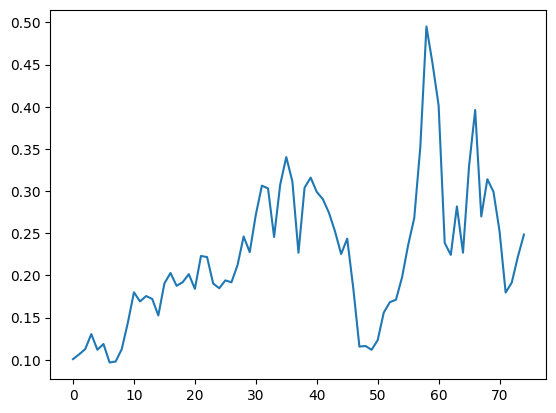

In [39]:
df_f['rsp'].plot()

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# # 1a) Convierte tu columna de fecha
# df_f['dateid01'] = pd.to_datetime(df_f['dateid01'])

# # 1b) Ponla como índice
# df_f = df_f.set_index('dateid01')

# # 1c) Ahora conviertes a PeriodIndex trimestral
# df_f.index = df_f.index.to_period('Q')

dlgp_q = df_f['rsp']

# --- 3) ADF Test (constante, SIC=BIC, maxlag=14) ---
adf_res = adfuller(dlgp_q, maxlag=11, regression='c', autolag='BIC')
adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adf_res

print("Null Hypothesis: DLGP has a unit root")
print("Exogenous: Constant")
print(f"Lag Length: {used_lag} (automatic via SIC, maxlag=11)\n")
print("\t\t t-Statistic\tProb.*")
print(f"ADF test statistic\t {adf_stat:.6f}\t {pvalue:.4f}\n")

print("Test critical values (MacKinnon 1996):")
for lvl, val in crit_vals.items():
    print(f"  {lvl} level\t {val:.6f}")
print("\n*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.\n")

# --- 4) Ecuación auxiliar ΔDLGP_t = α + β·DLGP_{t−1} + ∑γ_iΔDLGP_{t−i} + ε_t ---
df_aux = pd.DataFrame({
    'd_dlgp': dlgp_q.diff(),
    'dlgplag': dlgp_q.shift(1)
})
for i in range(1, used_lag+1):
    df_aux[f'd_dlgp_lag{i}'] = df_aux['d_dlgp'].shift(i)
df_aux = df_aux.dropna()

y = df_aux['d_dlgp']
cols = ['dlgplag'] + [f'd_dlgp_lag{i}' for i in range(1, used_lag+1)]
X = sm.add_constant(df_aux[cols])
model = sm.OLS(y, X).fit()

# --- 5) Tabla de coeficientes ---
print(model.summary().tables[1])

# --- 6) Métricas estilo EViews ---

# Durbin–Watson
dw_stat = durbin_watson(model.resid)

# HQIC (manual)
n = model.nobs
k = model.df_model + 1
hqic_val = -2*model.llf + 2*k*np.log(np.log(n))

# Información “por observación” (EViews):
aic_per_obs  = model.aic / n
bic_per_obs  = model.bic / n
hqic_per_obs = hqic_val   / n

print(f"\nR-squared:            {model.rsquared:.6f}    "
      f"Mean dependent var: {y.mean():.6f}")
print(f"Adj. R-squared:       {model.rsquared_adj:.6f}    "
      f"S.D. dependent var: {y.std():.6f}")
print(f"S.E. of regression:   {np.sqrt(model.mse_resid):.6f}    "
      f"Akaike info criterion: {aic_per_obs:.6f}")
print(f"Sum squared resid:    {model.ssr:.6f}    "
      f"Schwarz criterion:    {bic_per_obs:.6f}")
print(f"Log likelihood:       {model.llf:.4f}    "
      f"Hannan-Quinn criter.: {hqic_per_obs:.6f}")
print(f"F-statistic:          {model.fvalue:.6f}    "
      f"Prob(F-statistic):    {model.f_pvalue:.6f}")
print(f"Durbin-Watson stat:   {dw_stat:.6f}")

Null Hypothesis: DLGP has a unit root
Exogenous: Constant
Lag Length: 0 (automatic via SIC, maxlag=11)

		 t-Statistic	Prob.*
ADF test statistic	 -2.679183	 0.0777

Test critical values (MacKinnon 1996):
  1% level	 -3.521980
  5% level	 -2.901470
  10% level	 -2.588072

*Los ligeros descuadres (~0.0003) frente a EViews son por diferencias de interpolación.

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0391      0.015      2.643      0.010       0.010       0.069
dlgplag       -0.1659      0.062     -2.679      0.009      -0.289      -0.042

R-squared:            0.090657    Mean dependent var: 0.001997
Adj. R-squared:       0.078027    S.D. dependent var: 0.046615
S.E. of regression:   0.044760    Akaike info criterion: -3.348352
Sum squared resid:    0.144249    Schwarz criterion:    -3.286080
Log likelihood:       125.8890    Hannan-Quinn criter.: -3.3235

In [46]:
# Ambas series son cointegradas de orden 1.

In [ ]:
# Cointegrateed regression: la forma de estimar los coeficientes no cambia respecto OLS. 

In [9]:
import sys
!{sys.executable} -m pip install arch

   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 926.2/926.2 kB 5.3 MB/s eta 0:00:00


In [51]:
df_f = df.iloc[:75,:].copy()

In [28]:
from arch.unitroot.cointegration import FullyModifiedOLS

y = df_f['rsp']
X = df_f[['rdiv']]

# Instancia y ajusta FMOLS (constant trend por defecto)
mod = FullyModifiedOLS(y, X, trend='c')
res = mod.fit(kernel='bartlett', bandwidth=4)

print(res.summary())

                              Fully Modified OLS                              
Trend:                       Constant   No. Observations:                   75
Kernel:                      Bartlett   R²:                             0.7996
Bandwidth:                          4   Adjusted. R²:                   0.7969
                                        Residual Variance:              0.0014
                                        Long-run Variance:              0.0034
                                                                              
                             Cointegrating Vector                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
rdiv           20.687     1.9008     10.883     0.0000      16.961      24.412
const         -0.0122     0.0227    -0.5361     0.5919     -0.0568      0.0324


In [41]:
from statsmodels.tools.eval_measures import hqic
from statsmodels.stats.stattools import durbin_watson
import pandas as pd
import statsmodels.api as sm
from datetime import datetime

# 1) Datos y residuos de la primera etapa
#df = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')
y = df_f['rsp']
X = sm.add_constant(df_f[['rdiv']])
lev_mod = sm.OLS(y, X).fit()
resid = lev_mod.resid

# 2) Construir ΔRESID y RESID(-1)
d_resid   = resid.diff().dropna()
resid_lag = resid.shift(1).loc[d_resid.index]

# 3) Regresión auxiliar sin constante
aux_mod = sm.OLS(d_resid, resid_lag).fit()

# 4) Estadísticos básicos
now      = datetime.now()
nobs     = int(aux_mod.nobs)
coef     = aux_mod.params.iloc[0]
se       = aux_mod.bse.iloc[0]
tstat    = aux_mod.tvalues.iloc[0]
pval     = aux_mod.pvalues.iloc[0]
r2       = aux_mod.rsquared
r2adj    = aux_mod.rsquared_adj
mean_d   = d_resid.mean()
std_d    = d_resid.std()
srss     = (aux_mod.resid**2).sum()
ser      = aux_mod.scale**0.5
aic      = aux_mod.aic
bic      = aux_mod.bic
#  → calculamos HQIC manualmente:
k_params = aux_mod.df_model + 1
hqic_val = hqic(aux_mod.llf, nobs, k_params)
llf      = aux_mod.llf
dw       = durbin_watson(aux_mod.resid)
# sample0  = resid.index[1].year
# sample1  = resid.index[-1].year

# 5) Impresión con formato EViews
print(f"Engle–Granger Test Equation:")
print(f"Dependent Variable: D(RESID)")
print(f"Method: Least Squares")
print(f"Date: {now:%m/%d/%y}   Time: {now:%H:%M}\n")
# print(f"Sample (adjusted): {sample0}  {sample1}")
print(f"Included observations: {nobs} after adjustments\n")
print(f"{'Variable':<12}{'Coefficient':>12}{'Std. Error':>12}"
      f"{'t-Statistic':>12}{'Prob.':>10}")
print(f"RESID(-1){coef:12.6f}{se:12.6f}{tstat:12.6f}{pval:10.4f}\n")
print(f"R-squared{r2:12.6f}    Mean dependent var{mean_d:12.6f}")
print(f"Adjusted R-squared{r2adj:12.6f}    S.D. dependent var{std_d:12.6f}")
print(f"S.E. of regression{ser:12.6f}    Sum squared resid{srss:12.6f}")
print(f"Akaike info criterion{aic:12.6f}    Schwarz criterion{bic:12.6f}")
print(f"Log likelihood{llf:12.4f}    Hannan-Quinn criter.{hqic_val:12.6f}")
print(f"Durbin-Watson stat{dw:12.6f}")



Engle–Granger Test Equation:
Dependent Variable: D(RESID)
Method: Least Squares
Date: 05/04/25   Time: 21:21

Included observations: 74 after adjustments

Variable     Coefficient  Std. Error t-Statistic     Prob.
RESID(-1)   -0.363842    0.090287   -4.029832    0.0001

R-squared    0.181977    Mean dependent var    0.000237
Adjusted R-squared    0.170771    S.D. dependent var    0.032289
S.E. of regression    0.029205    Sum squared resid    0.062263
Akaike info criterion -311.950036    Schwarz criterion -309.645971
Log likelihood    156.9750    Hannan-Quinn criter. -308.111796
Durbin-Watson stat    1.820560


In [42]:
import pandas as pd
from arch.unitroot.cointegration import engle_granger, phillips_ouliaris
from datetime import datetime

# 1) Carga tus datos (ajusta la ruta si hace falta)
#df = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')
y = df_f['rsp']
X = df_f[['rdiv']]

# 2) Engle–Granger test (τ‑statistic, selección automática de lags por BIC, max_lags=11)
eg = engle_granger(y, X, trend='c', method='bic', max_lags=11)  # :contentReference[oaicite:0]{index=0}

# 3) Phillips–Ouliaris test (z‑statistic) con Bartlett bandwidth=4
po = phillips_ouliaris(y, X, trend='c', kernel='bartlett', bandwidth=4)  # :contentReference[oaicite:1]{index=1}

# 4) Resultados intermedios de la regresión ADF sobre los residuos
adf_reg = eg._adf.regression     # RegressionResults de la etapa ADF :contentReference[oaicite:2]{index=2}
gamma        = adf_reg.params.iloc[0]
se_gamma     = adf_reg.bse.iloc[0]
ssr          = adf_reg.ssr
df_resid     = adf_reg.df_resid
resid_var    = ssr / df_resid      # Residual variance (MSE)
long_run_var = resid_var          # Igual si lags=0
lags         = eg.lags            # Número de lags seleccionados
nobs         = int(adf_reg.nobs)  # Observaciones usadas en la ADF
stoch_trends = eg.distribution_order  # Número de tendencias estocásticas :contentReference[oaicite:3]{index=3}

# 5) Impresión con formato EViews
now = datetime.now()
print("Cointegration Test - Engle-Granger")
print(f"Date: {now:%m/%d/%y}   Time: {now:%H:%M}")
print("Equation: UNTITLED")
print("Specification: RSP RDIV C")
print("Cointegrating equation deterministics: C")
print("Null hypothesis: Series are not cointegrated")
print(f"Automatic lag specification (lag={lags} based on Schwarz Info Criterion,")
print("        maxlag=11)\n")

print("\t\tValue\tProb.*")
print(f"Engle–Granger tau-statistic\t{eg.stat: .6f}\t{eg.pvalue: .4f}")
print(f"Engle–Granger z-statistic\t{po.stat: .6f}\t{po.pvalue: .4f}\n")

print("*MacKinnon (1996) p-values.\n")

print("Intermediate Results:")
print(f"Rho - 1\t\t{gamma: .6f}")
print(f"Rho S.E.\t {se_gamma: .6f}")
print(f"Residual variance\t {resid_var: .6f}")
print(f"Long-run residual variance\t {long_run_var: .6f}")
print(f"Number of lags\t\t {lags}")
print(f"Number of observations\t {nobs}")
print(f"Number of stochastic trends**\t {stoch_trends}\n")

print("**Number of stochastic trends in asymptotic distribution.")


Cointegration Test - Engle-Granger
Date: 05/04/25   Time: 21:24
Equation: UNTITLED
Specification: RSP RDIV C
Cointegrating equation deterministics: C
Null hypothesis: Series are not cointegrated
Automatic lag specification (lag=0 based on Schwarz Info Criterion,
        maxlag=11)

		Value	Prob.*
Engle–Granger tau-statistic	-4.029832	 0.0066
Engle–Granger z-statistic	-3.980515	 0.0078

*MacKinnon (1996) p-values.

Intermediate Results:
Rho - 1		-0.363842
Rho S.E.	  0.090287
Residual variance	  0.000853
Long-run residual variance	  0.000853
Number of lags		 0
Number of observations	 74
Number of stochastic trends**	 1

**Number of stochastic trends in asymptotic distribution.


In [ ]:
#Lo último no coincide al detalle. P-value de tau, todo z, n° stochastic trends, todo FMOLS por decimales.

In [38]:
#min 1:35.

In [1]:
import numpy as np
import pandas as pd

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 2-20250504\termduffie.txt"
df = pd.read_csv(path, delimiter="\t", decimal=".")
df.head()

,Name,curv,dr,r10y,r1y,r2y,r3m,r5y,r6m,spread1,spread10,spread2,spread5
0,NaN,-0.000750,NaN,0.006241,0.004396,0.004721,0.003952,0.005416,0.004169,0.000444,0.002290,0.000770,0.001464
1,NaN,-0.000370,0.000600,0.006006,0.004837,0.005093,0.004551,0.005546,0.004672,0.000286,0.001454,0.000542,0.000995
2,NaN,-0.000427,-0.000062,0.006690,0.005066,0.005376,0.004490,0.006013,0.004808,0.000577,0.002200,0.000887,0.001523
3,NaN,-0.000318,0.000609,0.006337,0.005364,0.005558,0.005098,0.005895,0.005226,0.000266,0.001239,0.000460,0.000797
4,NaN,-0.000769,-0.000054,0.006827,0.005288,0.005551,0.005044,0.006153,0.005138,0.000244,0.001783,0.000507,0.001109


<Axes: >

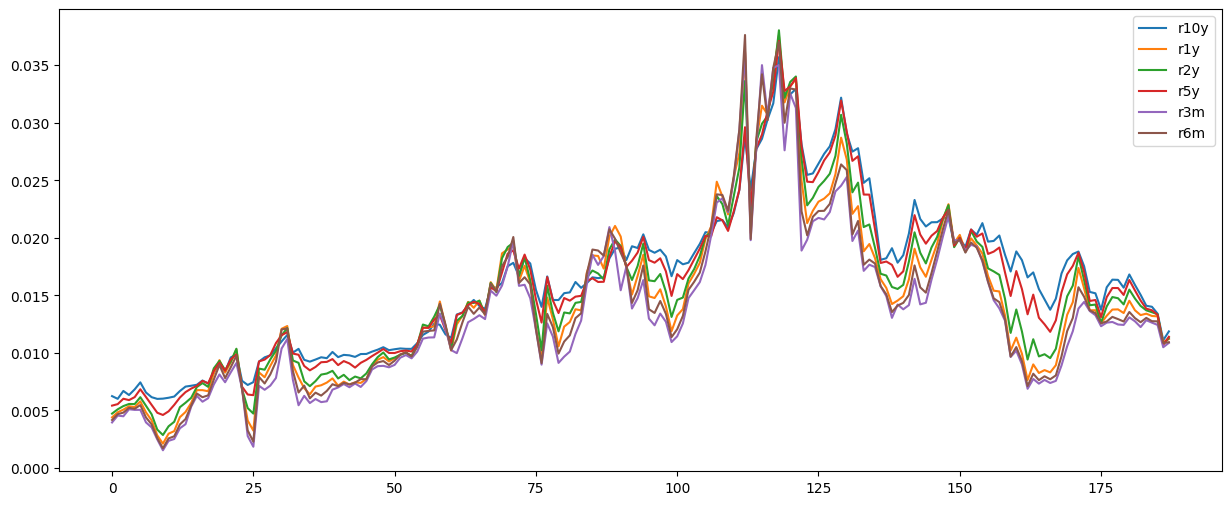

In [6]:
df[['r10y', 'r1y', 'r2y', 'r5y', 'r3m', 'r6m']].plot(figsize=(15,6))

In [7]:
# Veremos ECM. Min 1:39 explica limitaciones de EViews a la hora de determinar lag de ECM.

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank

# Suponiendo que ya cargaste tu DataFrame con columnas: 'r10y', 'r1y', ..., 'r6m'
# data = pd.read_csv("tus_datos.csv")  # Debe contener las columnas r10y, r1y, etc.
# Asegurarse de que no haya NaNs
data = df[['r10y', 'r1y', 'r2y', 'r3m', 'r5y', 'r6m']]

# Paso 1: Selección de rezagos óptimos (en tu caso: lags 1-12)
lag_order = select_order(data, maxlags=12, deterministic='ci')  # 'ci' = constante en cointegración
print(lag_order.summary())

# Elegimos lags = 2 porque VECM modela diferencias y necesita al menos k_ar_diff >= 1
# Si usás lag_interval 1 12 como en EViews, asegurate de que el lag óptimo esté dentro de ese rango
k_ar_diff = 2  # Esto implica lags de nivel hasta 3

# Paso 2: Determinar el rango de cointegración
coint_rank = select_coint_rank(data, det_order=0, k_ar_diff=k_ar_diff, method='trace', signif=0.05)
print(coint_rank.summary())

# Paso 3: Ajuste del modelo VECM
vecm = VECM(data, k_ar_diff=k_ar_diff, coint_rank=coint_rank.rank, deterministic='ci')
vecm_res = vecm.fit()

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -91.16     -90.29*   2.573e-40     -90.81*
1       -91.17      -89.65   2.554e-40      -90.55
2      -91.40*      -89.23  2.029e-40*      -90.52
3       -91.24      -88.42   2.394e-40      -90.10
4       -91.15      -87.68   2.666e-40      -89.74
5       -91.39      -87.26   2.134e-40      -89.72
6       -91.35      -86.58   2.262e-40      -89.42
7       -91.39      -85.96   2.255e-40      -89.19
8       -91.30      -85.22   2.579e-40      -88.83
9       -91.10      -84.37   3.321e-40      -88.37
10      -90.95      -83.57   4.118e-40      -87.95
11      -90.98      -82.95   4.333e-40      -87.72
12      -90.98      -82.30   4.751e-40      -87.46
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

In [18]:
# Cointegrating relationships (beta)
print("Cointegration vectors (beta):")
print(vecm_res.beta)

# Alpha (ajuste del ECM)
print("\nAdjustment coefficients (alpha):")
print(vecm_res.alpha)

# Resumen detallado con betas, alphas, y ecuaciones de corto plazo
print("\nSummary:")
print(vecm_res.summary())


Cointegration vectors (beta):
[[ 1.00000000e+00  5.29367142e-17 -1.10154219e-16 -1.03648121e-17
   7.75899149e-17]
 [ 3.21082735e-16  1.00000000e+00 -1.09075516e-16 -4.76112358e-17
  -5.41273346e-16]
 [-1.10988503e-16  7.30736795e-17  1.00000000e+00  4.82273260e-17
   1.18092504e-16]
 [ 2.87448296e-16  3.48848417e-17 -1.08967547e-16  1.00000000e+00
  -9.95874342e-17]
 [ 1.16787460e-15  2.84303353e-17  3.23207247e-16 -9.75823760e-17
   1.00000000e+00]
 [-1.06440395e+00 -1.01662388e+00 -1.03256356e+00 -9.88823540e-01
  -1.04653280e+00]]

Adjustment coefficients (alpha):
[[ 0.76677416 -0.1264244  -0.02510138  0.18689717 -1.02613183]
 [ 1.64974514  0.28476957  0.41507835  0.18222274 -2.28503323]
 [ 1.34227639  0.65636416 -0.41824802  0.24845861 -1.58192587]
 [ 2.32132214  0.7691835   1.23113137 -0.52453212 -3.68930279]
 [ 1.14661853 -0.20576122  0.16927857  0.15381809 -1.56602425]
 [ 1.98442263  0.96238227  0.70220259  0.09810165 -2.98407541]]

Summary:
Det. terms outside the coint. relati